# Notebook Setup (run me first!)

In [51]:
%matplotlib inline

In [52]:
import os
from pathlib import Path

import scipy as sp
import numpy as np
import pandas as pd

# we will need to plot stuff later
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

In [53]:
# if you cd'd to the repo folder before launching the jupyter lab server this should be fine
path_to_the_repo = os.getcwd() 
# Otherwise you'll have to set it manually
#path_to_the_repo = "/home/torradeflot/Projects/PythonBootcamp"

# SciPy
![SciPy](https://raw.githubusercontent.com/scipy/scipy-sphinx-theme/master/_static/scipyshiny_small.png)

- Uses numpy as its core
- Numerical methods for:
    + [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html): integration and ODEs
    + [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html): optimization and root finding
    + [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html): probability distributions and statistical functions
    + [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html): signal processing
    + [scipy.fft](https://docs.scipy.org/doc/scipy/reference/fft.html): Fast Fourier Transforms
    + And more: physical constants, spatial functions, linear algebra, etc
- Mostly build as wrappers around time-proven fortran libraries (fftpack, lapack, fitpack)

## Example 1: fitting Solar Photovoltaic generation data

Fitting a function with non-linear least squares using `curve_fit`


In [54]:
import scipy as sp
from scipy.optimize import curve_fit

In [55]:
daily_csv = os.path.join(path_to_the_repo, 'resources', 'power_sources_daily_2014_2023.csv')
df_daily = pd.read_csv(daily_csv, index_col=0)
df_daily.fillna(0, inplace=True)

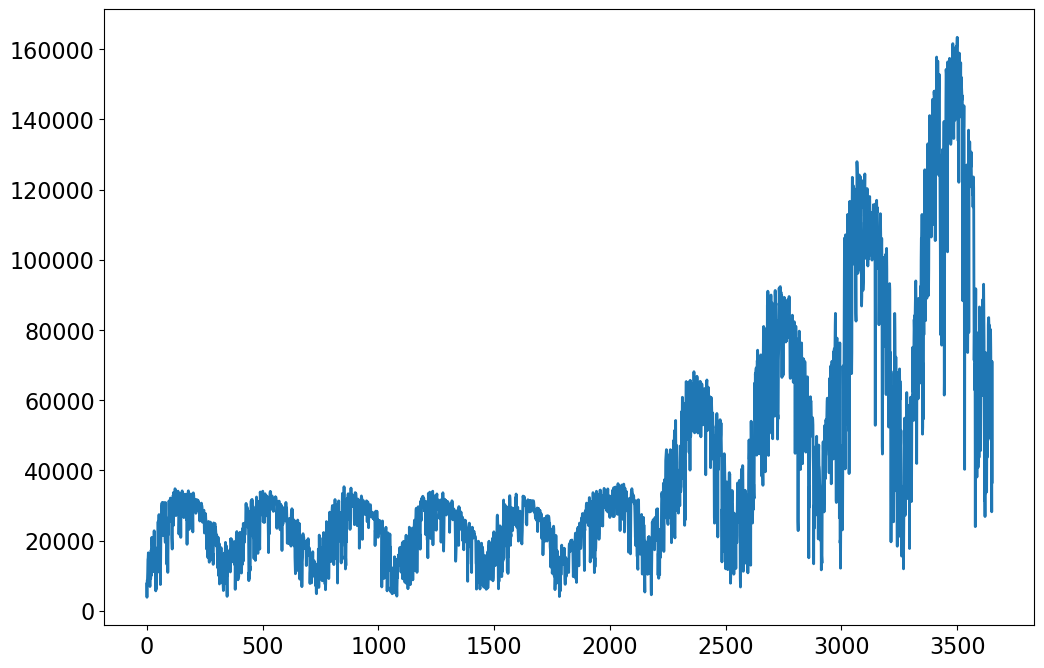

In [56]:
plt.plot(np.arange(len(df_daily)), df_daily['SolarPhotovoltaic'])

We want to fit a function to this data? which one?

Text(0.5, 1.0, 'Photovoltaic Energy Generation')

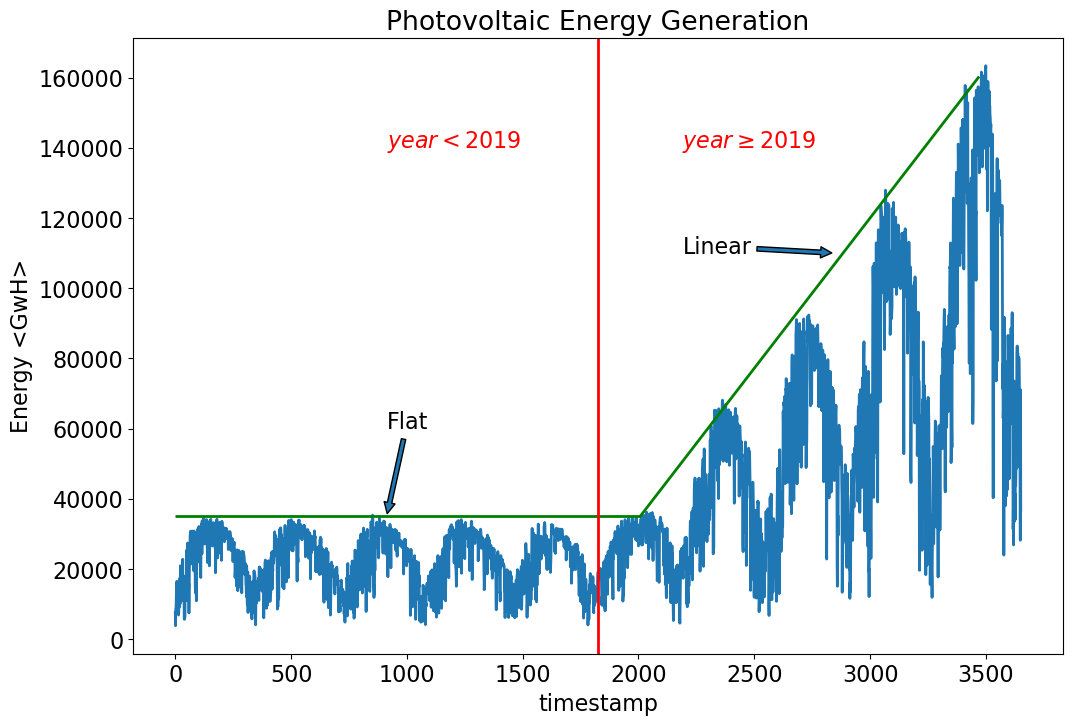

In [57]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df_daily)), df_daily['SolarPhotovoltaic'])
ax.hlines(35000, xmin=0, xmax=365*5.5, color='green')
ax.plot([365*5.5, 365*9.5], [35_000, 160_000], 'g-')
ax.annotate('Flat', xy=[2.5*365, 35_000], xytext=[2.5*365, 60_000],
            arrowprops={'arrowstyle': 'simple'})
ax.annotate('Linear', xy=[7.8*365, 110_000], xytext=[6*365, 110_000],
            arrowprops={'arrowstyle': 'simple'})
ax.axvline(5*365, color='r')
ax.text(2.5*365, 140_000, r'$year < 2019$', color='red')
ax.text(6*365, 140_000, r'$year \geq 2019$', color='red')
ax.set_xlabel('timestamp')
ax.set_ylabel('Energy <GwH>')
ax.set_title('Photovoltaic Energy Generation')

In [58]:
# %load -r 13:16 {path_to_the_repo}/session_5_miscellaneous/session_5_solutions.py

def photo_f(x, a,b,c,d,e):
    return a + b*x + c*x*np.sin(d + e*x)

In [59]:
year_mask = df_daily.year >= 2019
y = df_daily['SolarPhotovoltaic'][year_mask]
x = np.arange(len(y))

params, covariance_matrix = curve_fit(photo_f, x, y)
print(params)

[ 1.53254468e+04  4.97719665e+01  1.40064385e+00 -1.31169169e+01
  1.00878662e+00]


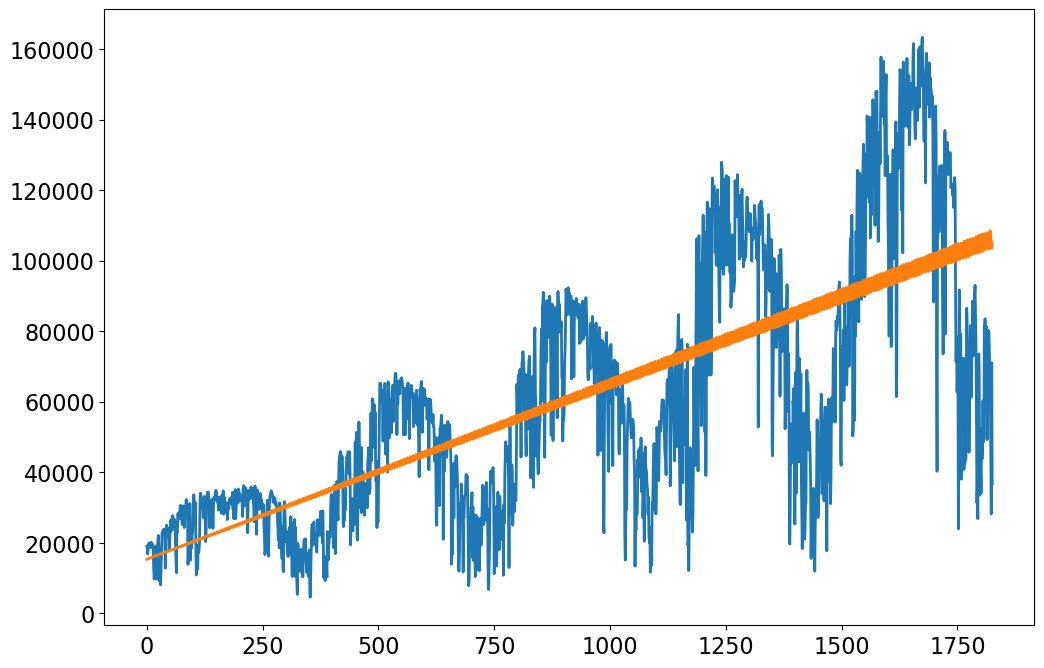

In [60]:
plt.plot(x, y)
plt.plot(x, photo_f(x, *params))

The results are not good, we approximante initial parameters

In [61]:
init_params = [20_000, 1, 1, 0, 365* 2*np.pi] 

In [62]:
# %load -r 17:19 {path_to_the_repo}/session_5_miscellaneous/session_5_solutions.py

[14182.05522113    51.31456656   -28.18752795    14.23289622
  2293.37988379]


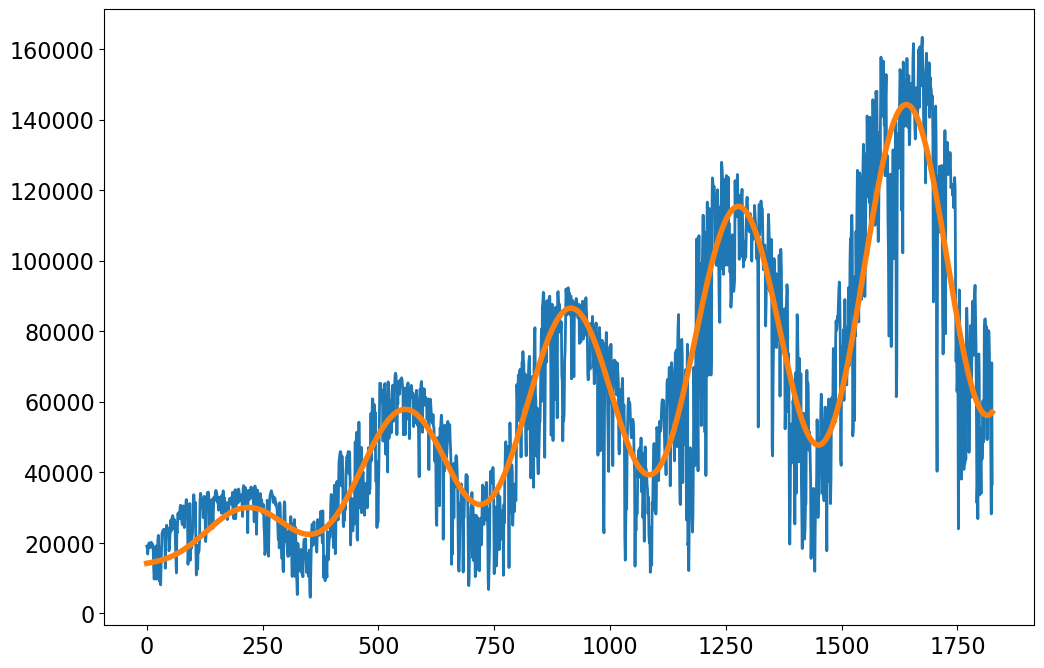

In [63]:
year_mask = df_daily.year >= 2019
y = df_daily['SolarPhotovoltaic'][year_mask]
x = np.arange(len(y))

params, covariance_matrix = curve_fit(photo_f, x, y, p0=init_params)
print(params)
plt.plot(x, y)
plt.plot(x, photo_f(x, *params), linewidth=4)

Text(0.5, 0.98, 'Daily Photovoltaic Energy Production in Spain $\\geq$ 2019')

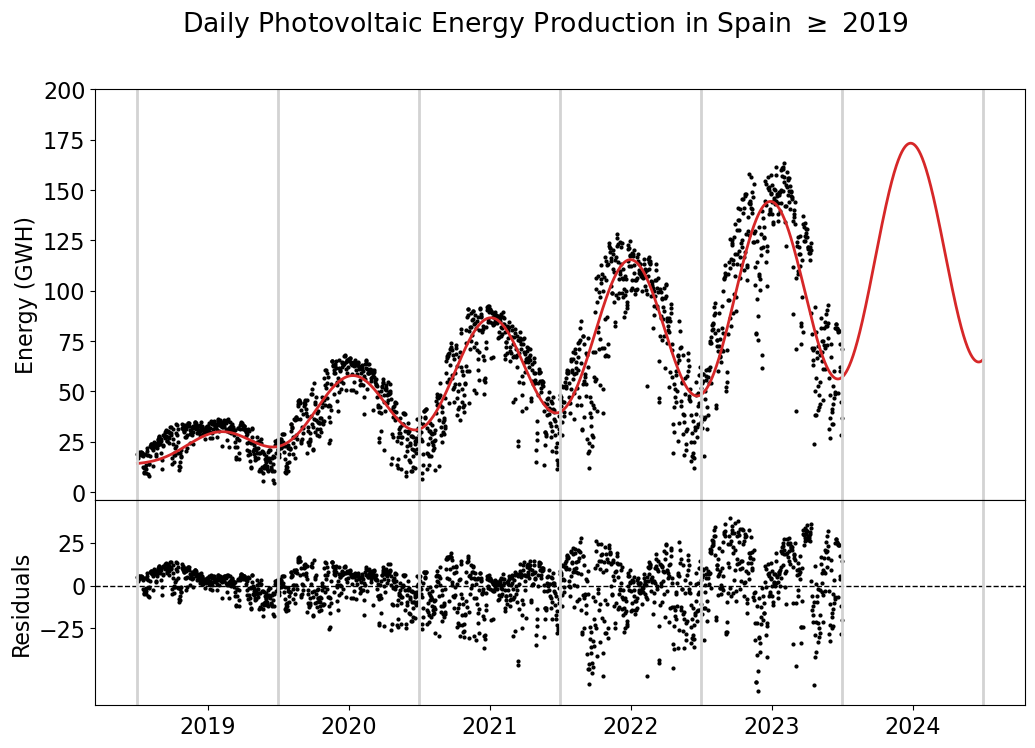

In [64]:
gridspec = {
    'height_ratios': [2, 1],
    'hspace': 0,
}
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=gridspec)

x2 = np.arange(len(y) + 365)

ax1.plot(x, y/1000, markersize=2, c='black', marker='o', linestyle='')
ax1.plot(x2, photo_f(x2, *params)/1000, c='tab:red', linewidth=2)
ax1.set_ylabel('Energy (GWH)')
ax1.set_yticks(ax1.get_yticks()[1:])    # remove bottom y-tick

ax2.plot(x, (y - photo_f(x, *params))/1000,
         markersize=2, c='black', marker='o', linestyle='')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
#ax2.set_xlabel('Energy')
ax2.set_ylim(-70, 50)
ax2.set_ylabel('Residuals')
ax2.set_yticks([-25, 0, 25])
ax2.set_xticks(np.arange(365.25/2, 365.25*6 + 1, 365.25))
ax2.set_xticklabels([str(i) for i in range(2019, 2025)])
for i in np.arange(0, 365.25*6 + 1, 365.25):
    ax2.axvline(i, c='lightgrey')
    ax1.axvline(i, c='lightgrey')

fig.suptitle(r'Daily Photovoltaic Energy Production in Spain $\geq$ 2019')

## Example 2: parameter estimation of random distribution

The scipy.stats module provides a very complete set of probability distributions.

There are three types of distributions:
* Continuous
* Discrete
* Multivariate

Each of the univariate types is inherited from the same class, so they all have a common API. Some of the methods in the API for Continuous distributions:

* `cdf`: Cumulative Distribution Function
* `pdf`: Probability Density Function
* `rvs`: Random Variable Sample
* `ppf`: Percent Point Function (inverse of the CDF)
* `fit`: return MLE estimations of location, scale and shape, given a set of data

In [65]:
from scipy import stats

import seaborn as sns

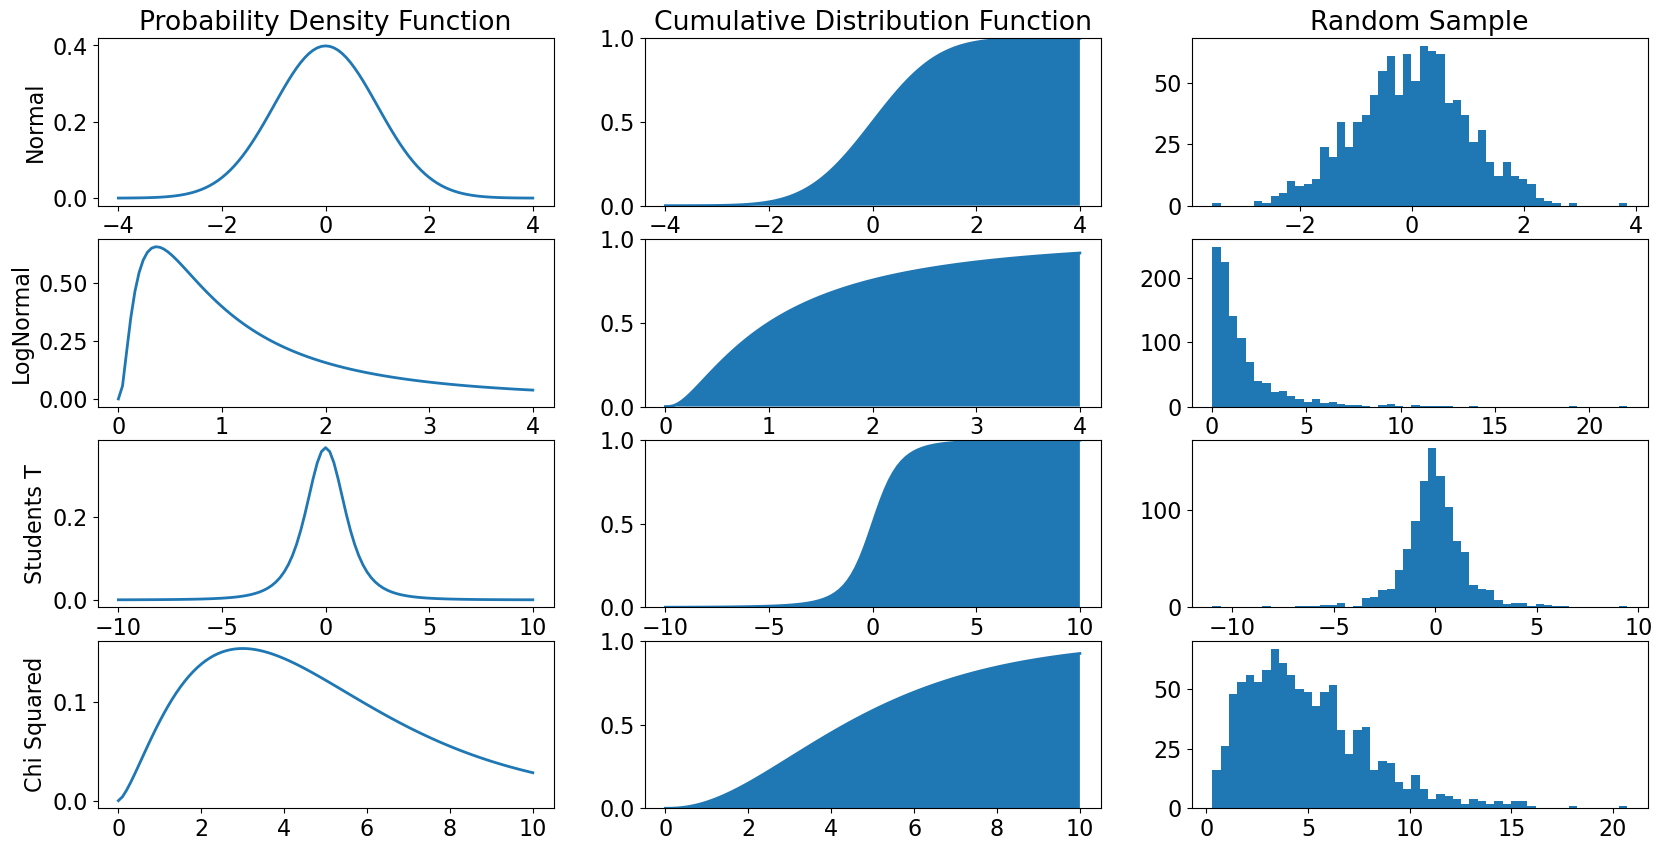

In [66]:
N_SAMPLES = 1000

# Name of the probability distribution, class, range of values to plot
pds = [('Normal', stats.norm(), (-4., 4.)), 
      ('LogNormal', stats.lognorm(1.), (0., 4.)),
      ('Students T', stats.t(3.), (-10., 10.)),
      ('Chi Squared', stats.chi2(5.), (0., 10.))]

n_pds = len(pds)
fig, ax_list = plt.subplots(n_pds, 3, figsize=(5.*n_pds, 10.))
for ind, elem in enumerate(pds):
    
    pd_name, pd_func, pd_range = elem

    x_range = np.linspace(*pd_range, 101)
    
    # Probability Density Function
    ax_list[ind, 0].plot(x_range, pd_func.pdf(x_range))
    ax_list[ind, 0].set_ylabel(pd_name)
    
    # Cumulative Distribution Function
    ax_list[ind, 1].plot(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].fill_between(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].set_ylim([0., 1.])
    
    # Random Variable Sample
    ax_list[ind, 2].hist(pd_func.rvs(size=N_SAMPLES), bins=50)
    
    if ind == 0:
        _ = ax_list[ind, 0].set_title('Probability Density Function')
        _ = ax_list[ind, 1].set_title('Cumulative Distribution Function')
        _ = ax_list[ind, 2].set_title('Random Sample')

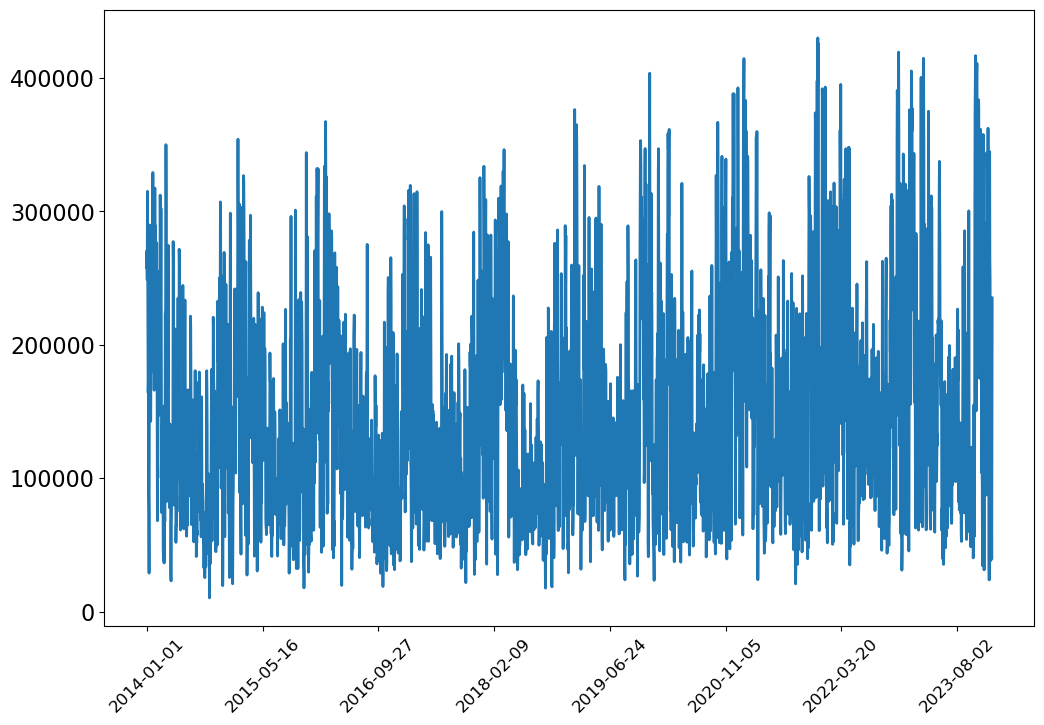

In [67]:
fig, ax = plt.subplots()
df_daily['Wind'].plot(ax=ax)
ax.tick_params(axis='x', labelsize=12, labelrotation=45)

gamma 0.4167274464975891
lognorm 0.05744591275321309
weibull_min 0.04016441550981198


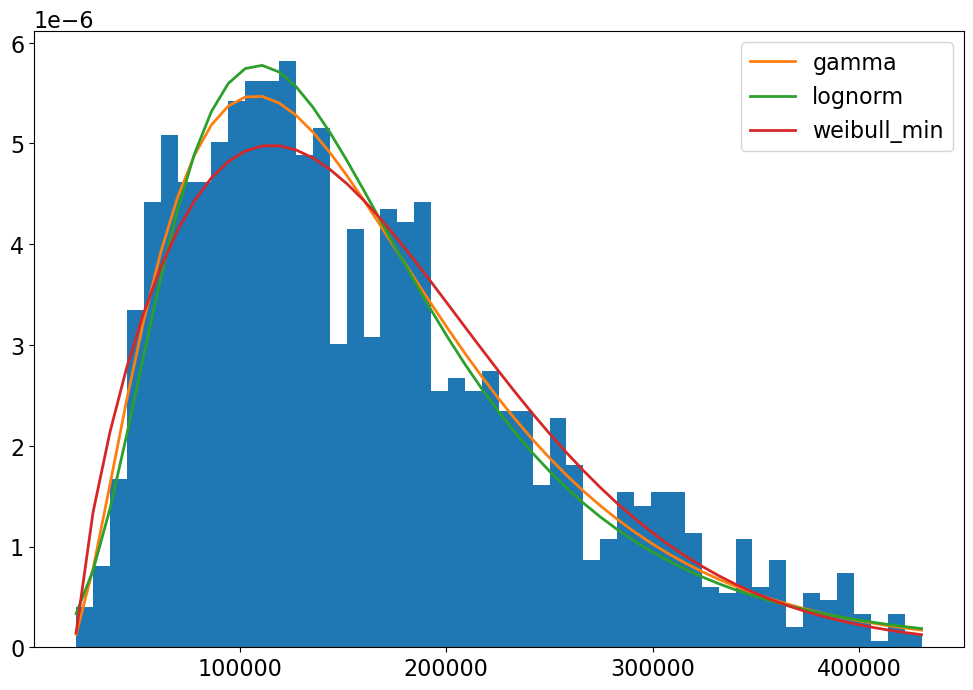

In [68]:
x = df_daily[df_daily.year>=2019]['Wind']

counts, bins, _ = plt.hist(x, density=True, bins=50)

for distro in ["gamma", "lognorm", "weibull_min"]:
    distro_func = getattr(stats, distro)
    params = distro_func.fit(x)
    plt.plot(bins, distro_func.pdf(bins, *params), label=distro)
    k, p = stats.kstest(x, distro_func(*params).cdf) #kolmogorov-smirnov test: check if the distribution fits the data
    print(distro, p)
plt.legend()

# Scikit-Learn (sklearn)

![sklearn logo](https://scikit-learn.org/stable/_images/scikit-learn-logo-notext.png)

Scikit-learn is a Python library containing hundreds of methods for machine learning purposes:
* Classification
* Regression
* Clustering
* Dimensionality Reduction
* Model selection
* Preprocessing

It is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

Your first easy-to-go choice when doing ML in python

If you want to use Deep Neural Networks, better look for a dedicated framework like [PyTorch](https://pytorch.org/)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC

## Datasets

scikit-learn contains some popular datasets and data generators

In [70]:
X, y = datasets.load_digits( return_X_y=True)

In [79]:
X, y 

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

What the hell is this?!

X si 8x8 images cada fila es una imatge (1,2,3,4,5,6,7,8,9), 65 columnes el valor de cada pixel, genera una imatge
y son els possible outcomes (1,2,3,4,5,6,7,8,9) predir cada fila quin numero representa la seva imatge

In [81]:
#%load -r 1:11 {path_to_the_repo}/session_5_miscellaneous/session_5_solutions.py

## Data loading, splitting

It contains utilities to split the dataset for training, cross-validation, hyperparameter tunning

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [74]:
# Train = 75%, Test=25% by default
X_train.shape, X_test.shape

((1347, 64), (450, 64))

## ML models

**Common API for all models** All models have the same API, it is then very easy to switch between different models during exploratory phase.

* `fit`: fit the model to the training data
* `predict`: evaluate the model
* `score`: compute the accuracy of the model

**Lots of algorithms included**

* **Supervised**: Linear regression, Logistic regression, Nearest Neighbours, Random Forest, Support Vector Machines, etc
* **Unsupervised**: Gaussian Mixtures Models, Principal Component Analysis (PCA), etc.

In [82]:
#SVC with default settings.
clf = SVC(kernel='poly')

# We learn the digits on the first half of the digits
clf.fit(X_train, y_train)

# Now predict the value of the digit on the test sample
y_prediction = clf.predict(X_test)

# Get the accuracy
clf.score(X_test, y_test)

0.9866666666666667

## Metrics

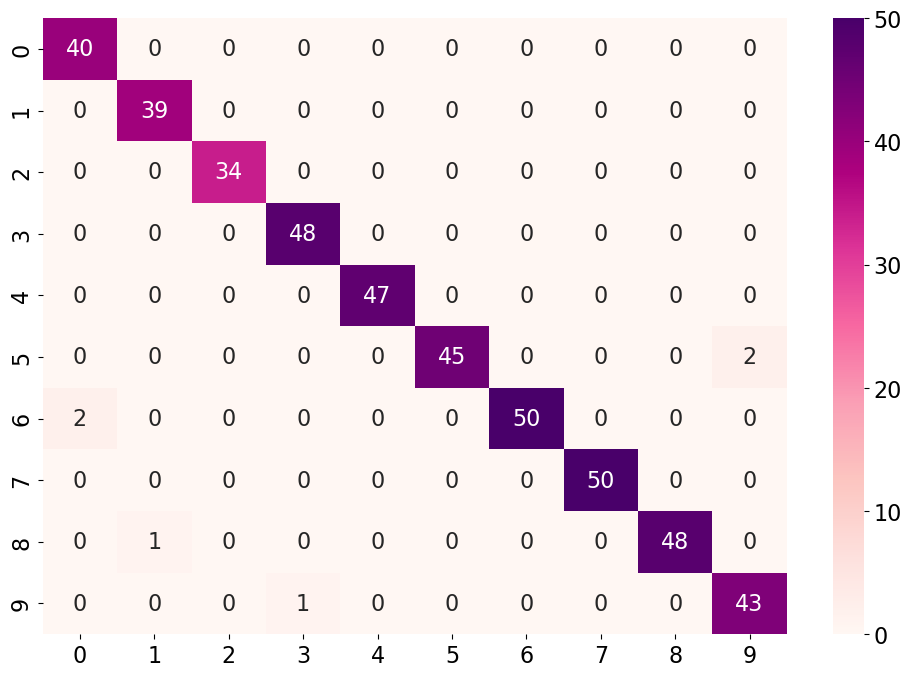

In [76]:
cm = confusion_matrix(y_test, y_prediction)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='RdPu',
)
None

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [78]:
a = accuracy_score(y_test, y_prediction)
p = precision_score(y_test, y_prediction, average='weighted')
r = recall_score(y_test, y_prediction, average='weighted')
a, p, r

(0.9866666666666667, 0.9870779793398841, 0.9866666666666667)

# Scale and speed up your analysis

## Distributed computing

When your dataset is too large to fit into a computer's memory or a single machine's CPU/GPU is not powerful enough, you need to scale your computation. Distributed computing allows you to process data and run calculations across multiple machines or CPU cores.

* **Dask** is the most important library for this in the Python ecosystem. It's a parallel computing library that integrates seamlessly with existing tools like NumPy and Pandas. Dask enables you to create "larger-than-memory" data structures, such as a Dask DataFrame or Dask Array, which lazily execute operations by splitting the work into smaller tasks and distributing them across a cluster. This allows you to scale your existing workflows to large-scale, out-of-core problems.

* **PySpark** is the Python API for Apache Spark, an open-source framework that distributes workloads across a cluster of machines. Spark is part of the Hadoop ecosystem and works smoothly with the Hadoop Distributed File System (HDFS), a framework for storing large files across multiple machines. Its core data structure is the DataFrame, very similar to the pandas one.


## GPU Acceleration

Graphics Processing Units (GPUs) are specialized processors designed for highly parallel computations. They contain thousands of small cores, making them ideal for tasks that can be broken down into many independent, simultaneous operations. For scientific computing, this translates to huge speedups for array operations, linear algebra, and machine learning. The most relevant libraries for this are:

* **CuPy** a drop-in replacement for NumPy, allowing you to run your existing NumPy code on an NVIDIA GPU simply by changing the import statement from numpy to cupy. The RAPIDS suite, including libraries like cuDF (for DataFrames) and cuML (for machine learning), offers similar GPU acceleration for Pandas and Scikit-learn workflows, often requiring little to no code change.

# Session 5 Exercise

It's time for the truth!

This week you will have to: **Build a machine learning algorithm to classify between spiral and elliptical galaxies using the catalog and image data to train a machine learning model**



Proposed approach: foto


he used 70000 images, x, y and color, so 3d, we have to redimension to pix1_1, pix1_2,..., pixN_N \
apply PCA to the features (the pixels) to get a subset, merge with the zoo spec

the PCA has to be applied first to the train data and then to the test

divendres: presentació  cada grup 10 minuts per ensenyar el nostre github repository. the cleaner the better. que ensenyi TOTS els pasos.

ensenyar l'score del ML, pero no es important com de accurate


PCA computes the correlation in all the columns, compites eigenvectors, so the bigger eigenvalues for the eiggenvectors with the correlation matter are used. its a linear transformation